# CNN Per‑Cell Magnitude Map — Seismic GNN Project

**Objective.** Learn a per‑cell magnitude map for the next time horizon from a 50×50 density grid of recent events.

**Spec.**
- **Input:** 50×50×1 density grid built from the last `LOOKBACK` events (with optional time‑decay; log1p transform).
- **Output:** 50×50×1 map where each cell is the **max magnitude** expected in the next `HORIZON_HOURS` hours.
- **Model:** Fully‑convolutional CNN (no flatten), 1×1 conv head → per‑cell regression using Huber loss.
- **Metrics:** MAE, RMSE (global, over all cells). Also parity plot, residuals, and qualitative true/pred maps.

### Setup

In [2]:

# Imports & repository path setup
import os
import sys
import json
import datetime as dt
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

NOTEBOOK_DIR: Path = Path().resolve()

REPO_ROOT: Path = NOTEBOOK_DIR if (NOTEBOOK_DIR / "src").exists() else NOTEBOOK_DIR.parent

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

# Printing Repository Root and Library Versions

print("Repository root:", REPO_ROOT)
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)

# Sanity checks
src_exists = (REPO_ROOT / "src").exists()
print("'src' directory found:", src_exists)
if not src_exists:
    print("Could not find a 'src' directory at:", REPO_ROOT / "src")

# Testing whether TensorFlow can see a GPU
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print(f"GPU detected ({len(gpus)}):", [g.name for g in gpus])
else:
    print("No GPU detected by TensorFlow — training will run on CPU.")


Repository root: D:\_4TH_YEAR_1ST_SEMESTER_STUFF\DL\DL Final Assignment\Seismic-GNN-Prediction
TensorFlow version: 2.17.1
NumPy version: 1.26.4
'src' directory found: True
No GPU detected by TensorFlow — training will run on CPU.


### Configuration

In [3]:
# Preview key runtime config values
from src.config import runtime as C

keys = [
    "GRID_SIZE","LOOKBACK","HORIZON_HOURS","LOG1P_INPUT","TIME_DECAY",
    "TRAIN_FRAC","VAL_FRAC","TEST_FRAC","SEED",
    "BATCH_SIZE","EPOCHS","LR","WEIGHT_DECAY","DROPOUT","USE_MIXED_PRECISION",
    "FALLBACK_DATA","ARTIFACTS"
]

for k in keys:
    print(f"{k:16s} =", getattr(C, k))

GRID_SIZE        = 50
LOOKBACK         = 50
HORIZON_HOURS    = 72
LOG1P_INPUT      = True
TIME_DECAY       = 0.0
TRAIN_FRAC       = 0.7
VAL_FRAC         = 0.15
TEST_FRAC        = 0.15
SEED             = 42
BATCH_SIZE       = 64
EPOCHS           = 100
LR               = 0.001
WEIGHT_DECAY     = 0.0001
DROPOUT          = 0.1
USE_MIXED_PRECISION = True
FALLBACK_DATA    = D:\_4TH_YEAR_1ST_SEMESTER_STUFF\DL\DL Final Assignment\Seismic-GNN-Prediction\data\interim\quakes_clean.csv
ARTIFACTS        = D:\_4TH_YEAR_1ST_SEMESTER_STUFF\DL\DL Final Assignment\Seismic-GNN-Prediction\artifacts\cnn\map


### Data

#### Load data and preview a sample

In [4]:
from src.data.loading import load_data_map

X_train, y_train, X_val, y_val, X_test, y_test = load_data_map()
print("Shapes:")
print("  X_train:", X_train.shape, " y_train:", y_train.shape)
print("  X_val:  ", X_val.shape,   " y_val:  ", y_val.shape)
print("  X_test: ", X_test.shape,  " y_test: ", y_test.shape)

# Sanity Checks: Value Ranges

print("X min/max:", float(X_train.min()), float(X_train.max()))
print("y min/max:", float(y_train.min()), float(y_train.max()))

Shapes:
  X_train: (1159, 50, 50, 1)  y_train: (1159, 50, 50, 1)
  X_val:   (248, 50, 50, 1)  y_val:   (248, 50, 50, 1)
  X_test:  (249, 50, 50, 1)  y_test:  (249, 50, 50, 1)
X min/max: 0.0 3.6888794898986816
y min/max: 0.0 7.099999904632568


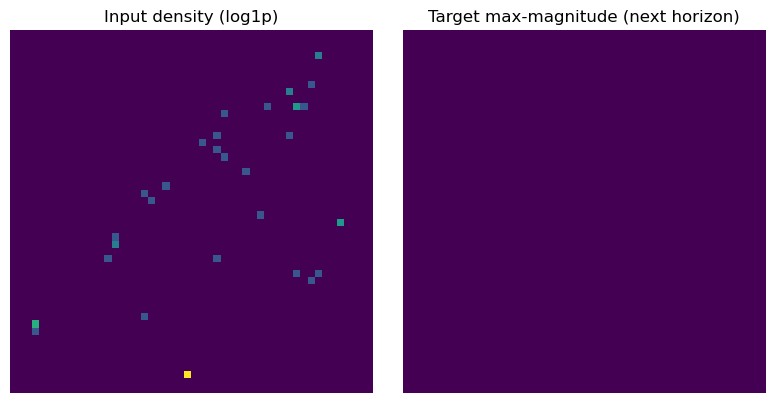

In [5]:
# Training Example Visualization (input density vs target magnitude map)
idx = 0
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].imshow(X_train[idx, ..., 0]); axs[0].set_title("Input density (log1p)")
axs[1].imshow(y_train[idx, ..., 0]); axs[1].set_title("Target max-magnitude (next horizon)")
for a in axs: a.axis("off")
plt.tight_layout(); plt.show()

### Model

#### Build CNN + Summary

In [6]:
from src.models.cnn.map_regressor import build_cnn_map

if C.USE_MIXED_PRECISION:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

model = build_cnn_map(input_shape=X_train.shape[1:], lr=C.LR, wd=C.WEIGHT_DECAY, dropout=C.DROPOUT)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 50, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 50, 50, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 50, 50, 1)      │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,057 (254.13 KB)

 Trainable params: 65,057 (254.13 KB)

 Non-trainable params: 0 (0.00 B)

### Training the CNN Model

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 175s 9s/step - loss: 0.0021 - mae: 0.0061 - rmse: 0.1269 - val_loss: 6.2318e-04 - val_mae: 0.0026 - val_rmse: 0.0635 - learning_rate: 0.0010
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 178s 9s/step - loss: 0.0018 - mae: 0.0050 - rmse: 0.1119 - val_loss: 7.7505e-04 - val_mae: 0.0030 - val_rmse: 0.0661 - learning_rate: 0.0010
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 180s 9s/step - loss: 0.0015 - mae: 0.0045 - rmse: 0.0964 - val_loss: 5.5580e-04 - val_mae: 0.0016 - val_rmse: 0.0641 - learning_rate: 0.0010
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 185s 10s/step - loss: 0.0013 - mae: 0.0035 - rmse: 0.0898 - val_loss: 5.7900e-04 - val_mae: 0.0021 - val_rmse: 0.0645 - learning_rate: 0.0010
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 181s 9s/step - loss: 0.0011 - mae: 0.0035 - rmse: 0.0842 - val_loss: 5.9623e-04 - val_mae: 0.0024 - val_rmse: 0.0651 - learning_rate: 0.0010
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 179s 9s/step - loss: 0.0011 - mae: 0.0032 - rmse: 0.0817 - v

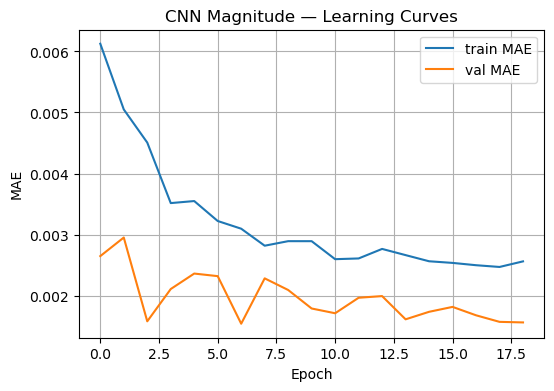

In [7]:
from tensorflow.keras import callbacks
from src.training.utils import ensure_dir, plot_learning_curves

tf.random.set_seed(C.SEED)

# Datasets
train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
            .shuffle(4096, seed=C.SEED).batch(C.BATCH_SIZE).prefetch(tf.data.AUTOTUNE))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(C.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(C.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Run directory
run_id = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
outdir = Path(C.ARTIFACTS) / f"map_run_{run_id}"
ensure_dir(outdir)

cbs = [
    callbacks.EarlyStopping(monitor="val_mae", patience=12, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_mae", patience=6, factor=0.5, min_lr=1e-6),
    callbacks.ModelCheckpoint(filepath=str(outdir / "best.keras"), monitor="val_mae", save_best_only=True),
    callbacks.CSVLogger(str(outdir / "history.csv")),
    callbacks.TensorBoard(log_dir=str(outdir / "tb")),
]

history = model.fit(train_ds, validation_data=val_ds, epochs=C.EPOCHS, callbacks=cbs, verbose=1)

# Save final model + history
model.save(outdir / "final.keras")
with open(outdir / "history.json", "w") as f:
    json.dump(history.history, f, indent=2)

plot_learning_curves(history)

## Evaluation

### Evaluate and visualize

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


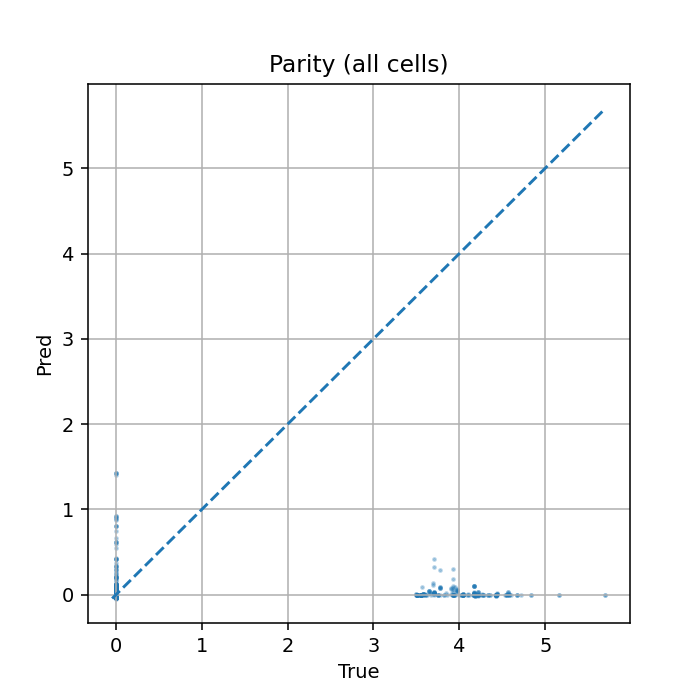

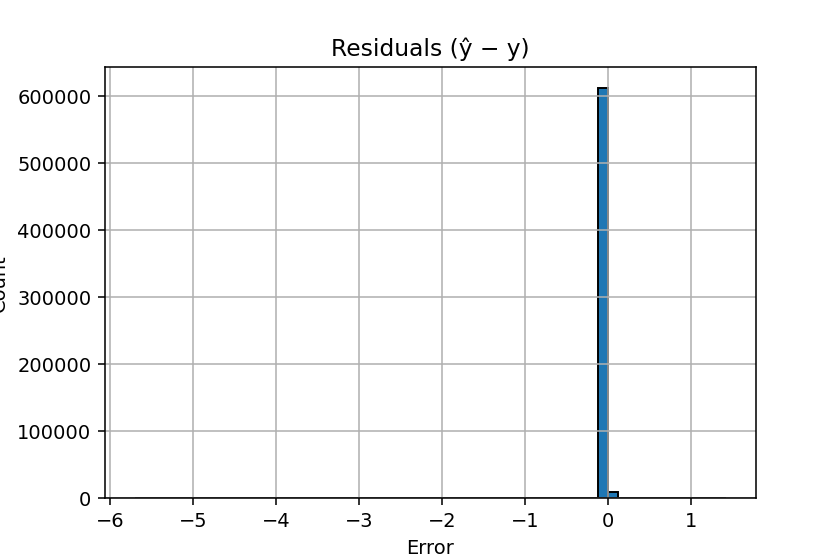

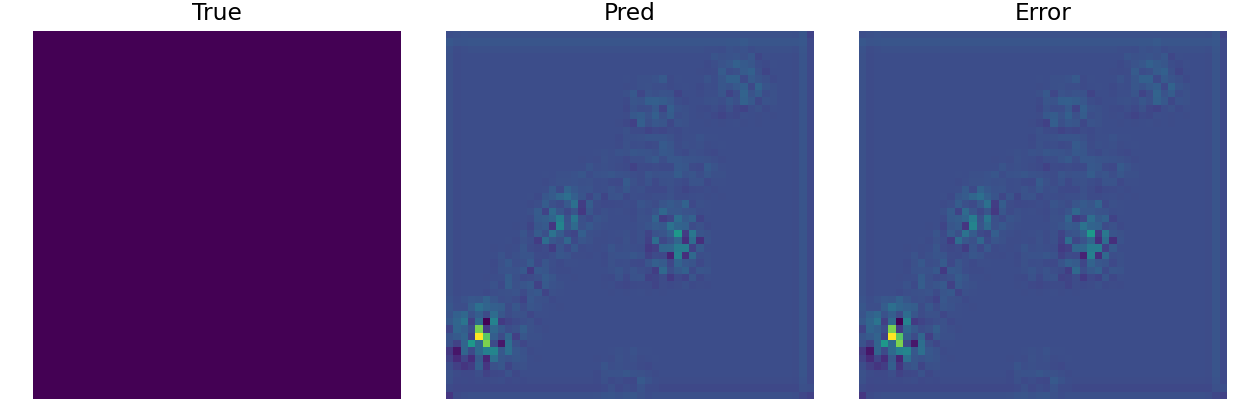

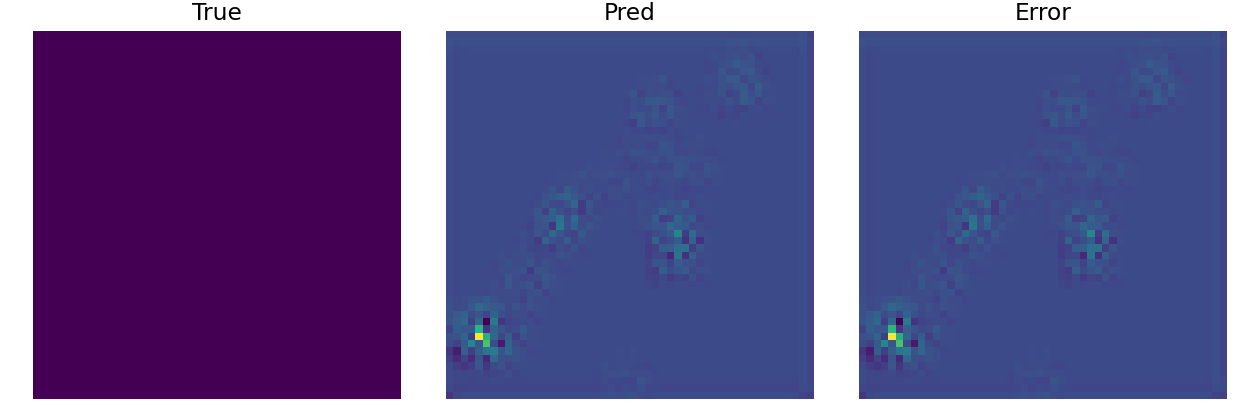

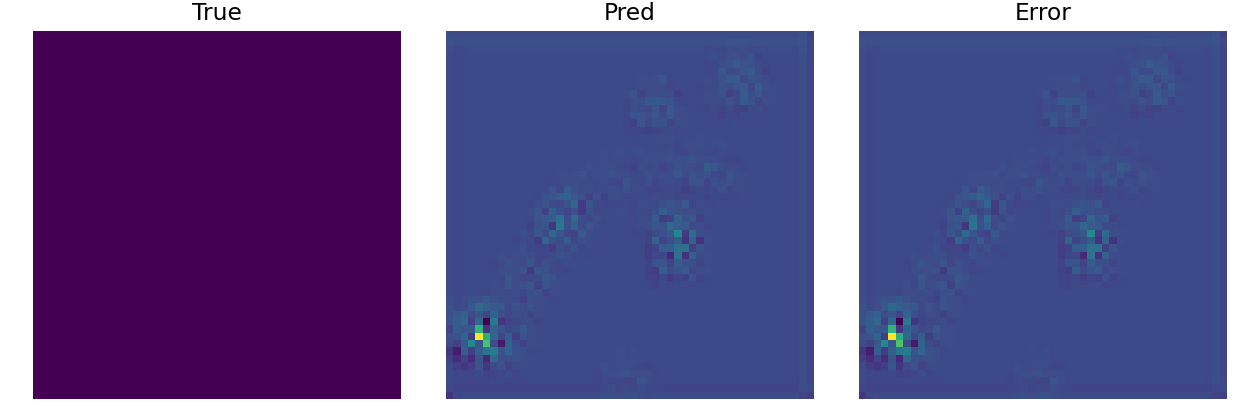

In [8]:
from src.evaluation.cnn.eval_map import eval_and_save

eval_dir = outdir / "eval"
eval_and_save(outdir / "best.keras", X_test, y_test, eval_dir)

# Show saved figures (if present)
from IPython.display import display, Image
for name in ["parity.png", "residuals.png", "sample_0.png", "sample_1.png", "sample_2.png"]:
    p = eval_dir / name
    if p.exists():
        display(Image(filename=str(p)))